## Load packages

In [45]:
# Useful packages
import os
import warnings

# Work with Python array and graphs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Cluster tendency
from pyclustertend import hopkins

# Mapping
from sklearn.metrics import pairwise_distances, accuracy_score
from coclust.evaluation.external import accuracy
from skbio.stats.ordination import pcoa
from multiview.mvmds import mvmds

# Clustering algorithm
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from KMedoidsPaper import KMedoids

# Clustering performance evaluation
from sklearn.metrics import davies_bouldin_score, silhouette_score

//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [46]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

umap==0.1.1
scikit-learn==0.22.1
numpy==1.17.0
matplotlib==3.2.1


## Load data

In [47]:
ISC_EDA = np.genfromtxt(os.path.join('school_EDA.csv'),delimiter=',')
ISC_EDA = np.array(ISC_EDA,dtype='float') # Convert into array

ISC_IBI = np.genfromtxt(os.path.join('school_IBI.csv'),delimiter=',')
ISC_IBI = np.array(ISC_IBI,dtype='float') # Convert into array

print(ISC_EDA[:4,:4])
print(ISC_IBI[:4,:4])

[[        nan         nan         nan         nan]
 [        nan  1.         -0.03141639  0.03757098]
 [        nan         nan  1.         -0.03700345]
 [        nan         nan         nan  1.        ]]
[[ 1.         -0.00627267 -0.04502398  0.02268373]
 [        nan  1.          0.03795474  0.07132264]
 [        nan         nan  1.         -0.04432404]
 [        nan         nan         nan  1.        ]]


## Pre processing specific to these matrices

In [48]:
# Symetrical matrices
ISC_EDA = np.nan_to_num(ISC_EDA)
ISC_IBI = np.nan_to_num(ISC_IBI)
ISC_EDA = (ISC_EDA+ISC_EDA.T)/2
ISC_IBI = (ISC_IBI+ISC_IBI.T)/2

print(ISC_EDA[:4,:4])
print(ISC_IBI[:4,:4])

[[ 0.          0.          0.          0.        ]
 [ 0.          1.         -0.0157082   0.01878549]
 [ 0.         -0.0157082   1.         -0.01850172]
 [ 0.          0.01878549 -0.01850172  1.        ]]
[[ 1.         -0.00313633 -0.02251199  0.01134186]
 [-0.00313633  1.          0.01897737  0.03566132]
 [-0.02251199  0.01897737  1.         -0.02216202]
 [ 0.01134186  0.03566132 -0.02216202  1.        ]]


In [49]:
# Remove rows with NaNs
def removeNaNSubject(matrix,subject):
    new_mat = np.copy(matrix)
    new_mat = np.delete(new_mat, (subject), axis=0)
    new_mat = np.delete(new_mat, (subject), axis=1)
    
    '''
    with open(os.path.join('school_EDA_truncated.csv'), 'w') as File:
        writer = csv.writer(File,delimiter =';')
        writer.writerows(matrix)
    '''
    
    return new_mat
# Remove outlier in vector if we find one
def removeSubjectsVector(vector,subjects):
    new_vect = np.copy(vector)
    for subj in subjects:
        new_vect = np.delete(new_vect, (subj), axis=0)
    
    return new_vect

last_i = 0
i = 0
subjectsRemoved = []
nbTotal = len(ISC_EDA)
while (last_i < nbTotal and i < nbTotal - 1):
    #print(nbTotal)
    for i in range(nbTotal):
        #print(i)
        if ISC_EDA[0,i] == 0.:
            ISC_EDA = removeNaNSubject(ISC_EDA,i)
            last_i = i
            nbTotal -= 1
            #subjectsRemoved.append(i - nbTotal + 84)
            subjectsRemoved.append(i)
            break

    #print(last_i)
    
print(ISC_EDA[:4,:4])
print(subjectsRemoved)

[[ 1.         -0.0157082   0.01878549  0.04346148]
 [-0.0157082   1.         -0.01850172  0.00829478]
 [ 0.01878549 -0.01850172  1.          0.03265855]
 [ 0.04346148  0.00829478  0.03265855  1.        ]]
[0, 51, 55, 56]


## Compute distance matrix

In [50]:
def computeDistanceMatrix(study_matrix):
    
    # Normalise maximum value to 1
    normed_matrix = np.copy(study_matrix)
    normed_matrix = normed_matrix / np.max(abs(normed_matrix))
    
    # Convert into distance matrix
    distance_matrix = np.sqrt((1-normed_matrix)) # Formula in Matlab and in Scikit to convert 
        
    # Interval MDS normalization to spread values between 0 and 1
    a = np.min(np.sort(distance_matrix,axis=0)[1,:])
    distance_matrix = distance_matrix - a
    distance_matrix = distance_matrix - np.diag(np.diag(distance_matrix))
    distance_matrix = distance_matrix / np.max(distance_matrix)
    
    # To make sure output is perfectly symmetrical
    return (distance_matrix+distance_matrix.T)/2

## Multiview mapping

In [51]:
'''
def computeAllDistanceMatrix(ISC_EDA,ISC_IBI):
    
    # Make copy of 2 matrices (for each modality)
    mat_EDA = np.copy(ISC_EDA)
    mat_IBI = np.copy(ISC_IBI)
    
    # Compute the 2 distance matrices (according to each modality)
    distance_matrix_EDA = computeDistanceMatrix(ISC_EDA)
    distance_matrix_IBI = computeDistanceMatrix(ISC_IBI)
  
    # Remove direct correlation influence and compute correlation distance matrices
    for i in range(len(ISC_EDA)):
        mat_EDA[i,i] = 0
        mat_IBI[i,i] = 0
    distance_matrix_corr_EDA = pairwise_distances(mat_EDA,metric='correlation')
    distance_matrix_corr_IBI = pairwise_distances(mat_IBI,metric='correlation')

    # Return distance matrices
    return distance_matrix_EDA, distance_matrix_IBI, distance_matrix_corr_EDA, distance_matrix_corr_IBI
'''

"\ndef computeAllDistanceMatrix(ISC_EDA,ISC_IBI):\n    \n    # Make copy of 2 matrices (for each modality)\n    mat_EDA = np.copy(ISC_EDA)\n    mat_IBI = np.copy(ISC_IBI)\n    \n    # Compute the 2 distance matrices (according to each modality)\n    distance_matrix_EDA = computeDistanceMatrix(ISC_EDA)\n    distance_matrix_IBI = computeDistanceMatrix(ISC_IBI)\n  \n    # Remove direct correlation influence and compute correlation distance matrices\n    for i in range(len(ISC_EDA)):\n        mat_EDA[i,i] = 0\n        mat_IBI[i,i] = 0\n    distance_matrix_corr_EDA = pairwise_distances(mat_EDA,metric='correlation')\n    distance_matrix_corr_IBI = pairwise_distances(mat_IBI,metric='correlation')\n\n    # Return distance matrices\n    return distance_matrix_EDA, distance_matrix_IBI, distance_matrix_corr_EDA, distance_matrix_corr_IBI\n"

In [52]:
def computeAllDistanceMatrix(ISC_EDA,ISC_IBI):
    
    # Make copy of 2 matrices (for each modality)
    mat_EDA = np.copy(ISC_EDA)
    
    # Compute the 2 distance matrices (according to each modality)
    distance_matrix_EDA = computeDistanceMatrix(ISC_EDA)
  
    # Remove direct correlation influence and compute correlation distance matrices
    for i in range(len(ISC_EDA)):
        mat_EDA[i,i] = 0
    distance_matrix_corr_EDA = pairwise_distances(mat_EDA,metric='correlation')

    # Return distance matrices
    return distance_matrix_EDA, distance_matrix_corr_EDA

In [53]:
def computeCoordinate(mat=['EDA','IBI','corrEDA','corrIBI'],added=False):

    # Compute all distance matrices
    #distance_matrix_EDA, distance_matrix_IBI, distance_matrix_corr_EDA, distance_matrix_corr_IBI = computeAllDistanceMatrix(ISC_EDA,ISC_IBI)    
    distance_matrix_EDA, distance_matrix_corr_EDA = computeAllDistanceMatrix(ISC_EDA,ISC_IBI)    

    # Choose which matrices to include into the multiview
    multiviewMat = []
    if ('EDA' in mat):
        multiviewMat.append(distance_matrix_EDA)
        distance_matrix = distance_matrix_EDA
    if ('IBI' in mat):
        multiviewMat.append(distance_matrix_IBI)
        distance_matrix = distance_matrix_IBI
    if ('corrEDA' in mat):
        multiviewMat.append(distance_matrix_corr_EDA)
    if ('corrIBI' in mat):
        multiviewMat.append(distance_matrix_corr_IBI)
        
    # Compute mapping
    embeddingDim = 2 # to have a 2D map
    
    if len(mat)==1:
        points = np.array(pcoa(distance_matrix, method='eigh', number_of_dimensions=embeddingDim).samples)
        print("pcoa proportion explained : %s " %np.sum(pcoa(distance_matrix, method='eigh', number_of_dimensions=embeddingDim).proportion_explained))
    else:
        points = mvmds(multiviewMat,len(mat)*[True],embeddingDim,added=added)
    
    return points

In [54]:
import umap.umap_ as umap
from sklearn import preprocessing

def computeUMAPCoordinate(mat,sslLabel=None,n_neighbors=3):

    if (mat==['EDA']):
        study_matrix = ISC_EDA
    if (mat==['IBI']):
        study_matrix = ISC_IBI

    fitter = umap.UMAP(n_neighbors=n_neighbors,metric='correlation',min_dist=0.0,init='spectral',target_weight=0.5,n_epochs=5000).fit(study_matrix,sslLabel)
    #points = preprocessing.scale(fitter.embedding_,axis=0)
    points = (fitter.embedding_ - np.mean(fitter.embedding_,axis=0)) / np.std(fitter.embedding_,axis=0)
    print(np.std(points))
    print(np.mean(points))
    return points

## Compute clustering

In [74]:
class Results():

    def __init__(self,mat,mapping,algo):
        self.mat = mat
        self.mapping = mapping
        self.algo = algo
        
    def twoClustersMethodResult(self):
        print("Blind results\n")
        
        # Cluster tendency
        print("Hopkins test")
        self.hopkinsCoef()
        print("%f +- %f" %(self.hopkins[0],self.hopkins[1]))
        
        # Found clusters
        print("Found clusters ")
        print(self.label)
        
        # Clustering quality evaluation
        print("Silhouette coefficient : %0.3f" %self.silhouetteCoef())
        print("DB index : %f " %self.dbScore())
        
        # Comparing to ground truth (if known)
        if (os.path.isfile(os.path.join('condition.csv'))):
            global groundTruth
            if (groundTruth):
                print("\n\nComparing to ground truth\n")
                print("Accuracy : %f " %self.accuracy())
                print("Misclassified participants : [%s]" % ", ".join(map(str, self.misClassified)))        
        
    def applyMethod(self,method):
        
        # Mapping
        if (mapping == 'UMAP'):
            points = computeUMAPCoordinate(self.mat)
            print(points)
        elif (mapping == 'MDS'):
            points = computeCoordinate(self.mat,added=False)
        elif (mapping == 'MDS_scale'):
            points = computeCoordinate(self.mat,added=True)
        
        # Clustering
        # if (meth.distance_matrix):
        if (algo == 'K-Medoids'):
            meth = method.fit(pairwise_distances(points))
        else:
            meth = method.fit(points)

        # Store found labels and points location
        if hasattr(meth, 'labels_'):
            label = meth.labels_
        else:
            label = meth.predict(points)
        self.label = label
        self.best_points = points
         
    def showResultMap(self):
        
        # Set new figure
        plt.figure()
        ax = plt.axes([0,0,1.2,1.2])
        ax.set_aspect(aspect='equal')
        
        # Annotate points
        for i in range(len(ISC_EDA)):
            ax.annotate(i,(self.best_points[i,0],self.best_points[i,1]),xytext=(self.best_points[i,0]+(np.max(self.best_points[:,0])-np.min(self.best_points[:,0]))/50,self.best_points[i,1]))     
        
        # Show color according to trueDisplay bool
        global trueDisplay
        if (trueDisplay):
            # Scatter points
            for i in range(n_clusters):
                ax.scatter(self.best_points[self.trueGroups[i],0],self.best_points[self.trueGroups[i],1],s=145,label=str(i))
            
            # Add legend
            TP = mpatches.Patch(color='blue', label='NA')
            TN = mpatches.Patch(color='red', label='SSA')
            FP_FN = mpatches.Patch(color='black', label='misclassified')
            plt.legend(handles=[TP,TN,FP_FN])
            plt.title("%s on [%s]" % (self.algo, ", ".join(map(str, self.mat))))
            plt.axis('off')
            #axes = plt.gca()
            #axes.set_xlim([-0.4,0.4])
            #axes.set_ylim([-0.4,0.7])
            plt.savefig(os.path.join('figures','GT_%s.png' %self.mat),bbox_inches='tight')
        else:
            # Scatter points
            for i in range(n_clusters):
                ax.scatter(self.best_points[self.label == i,0],self.best_points[self.label == i,1],s=145,label=str(i))
            
            # Add legend
            group0 = mpatches.Patch(color='darkgreen', label='First group')
            group1 = mpatches.Patch(color='darkorange', label='Second group')
            plt.legend(handles=[group0,group1])       
            plt.title("%s on [%s]" % (self.algo, ", ".join(map(str, self.mat))))
            plt.axis('off')
            plt.savefig(os.path.join('figures','clustering_%s.png' %self.mat),bbox_inches='tight')

        
    def dbScore(self):
        # Compute DB-score (small means good clustering)
        if len(np.unique(self.label))==1:
            warnings.warn("Labels correspond to only 1 group")
            return -1
        elif len(np.unique(self.label))==len(ISC_EDA):
            warnings.warn("Each participant correspond to one label")
            return -1
        else:
            return davies_bouldin_score(self.best_points,self.label)
        
    def hopkinsCoef(self):
        # Average on different random data generated in Hopkins
        H = []
        for p in range(100):
            H.append(hopkins(self.best_points,len(ISC_EDA)))   
        self.hopkins = [1-np.mean(H),np.std(H)]
        
        # Raise a warning if Hopkins test <= 0.5
        if (self.hopkins[0]<=0.5):
            warnings.warn("Hopkins test <= 0.5 : data set does not have clustering tendency")
            
    def silhouetteCoef(self):
        # Compute Silhouette Coefficient based on distance matrix (the closer it is to 1, the better the clustering is)
        if len(np.unique(self.label))==1:
            warnings.warn("Labels correspond to only 1 group")
            return -1
        elif len(np.unique(self.label))==len(ISC_EDA):
            warnings.warn("Each participant correspond to one label")
            return -1
        else:
            return silhouette_score(self.best_points, self.label, metric='euclidean')
        
    def accuracy(self):
        # Read true labels from CSV file
        condition = np.genfromtxt(os.path.join('conditionSchool.csv'),delimiter=',')
        condition = np.array(condition,dtype='int') # Convert into array
        condition = removeSubjectsVector(condition,subjectsRemoved)
        self.trueGroups = []
        for i in range(n_clusters):
            self.trueGroups.append(np.where(condition == i)[0])
        
        # Find which participants are misclassified and compute accuracy
        subjects = np.arange(len(ISC_EDA))
        self.wellClassified = subjects[self.label==condition]
        self.misClassified = subjects[self.label!=condition]
        '''if (len(self.misClassified) > len(self.wellClassified)):
            self.wellClassified, self.misClassified = self.misClassified, self.wellClassified
        
        return len(self.wellClassified) / len(ISC_EDA)
        '''
        
        return accuracy(condition,self.label)

In [76]:
# Choose which matrix or matrices to study
mat = ['EDA']
#mat = ['EDA','IBI']

# Decide if compare to ground truth
groundTruth = True

# Display found clusters or true clusters with misclassified participants in black
trueDisplay = True

# Choose mapping method
mapping = 'UMAP'
mapping = 'MDS'
mapping = 'MDS_scale'

# Choose clustering algorithm
algo = 'K-Means'
algo = 'Spectral Clustering'
algo = 'Hierarchical Clustering'
#algo = 'K-Medoids'

//anaconda3/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.7002649456844616 and the largest is 1.5618709971442637.
  RuntimeWarning


pcoa proportion explained : 0.110789991558776 
Blind results

Hopkins test
0.641478 +- 0.020513
Found clusters 
[16 13 13  6  0  4  8  2  4  0 10 15 14  4 14  6  8 12  3  7 15 14  2  5
  6 13  6 10 15  4 16  0  5  3 11  1  7  8  3  5 13  0  3 15  7 13  1  6
  3  6 10  6  6 11  0  8  0  7  3  7 15  1  8  2  5  1  7 15  5  2  7 16
 10 15 15  4  3 14  7  9  5]
Silhouette coefficient : 0.395
DB index : 0.652299 


Comparing to ground truth

Accuracy : 0.308642 
Misclassified participants : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80]


//anaconda3/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


0.4619722729227039


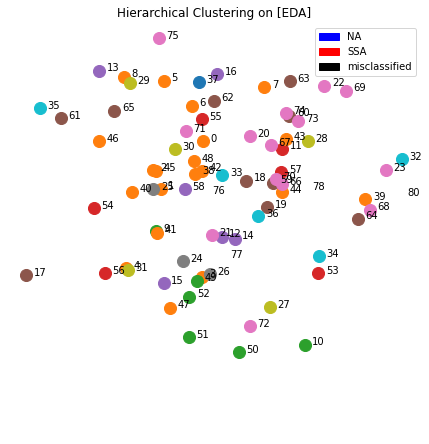

<Figure size 432x288 with 0 Axes>

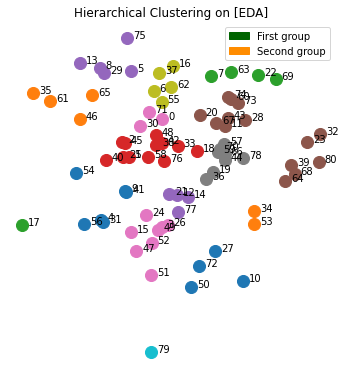

In [77]:
# Compute chosen clustering
method_result = Results(mat=mat,mapping=mapping,algo=algo)
n_clusters = 17
if (algo == 'K-Means'):
    method = KMeans(n_clusters=n_clusters,n_init=100)
elif (algo == 'Spectral Clustering'):
    method = SpectralClustering(n_clusters=n_clusters,n_init=10,gamma=1)
elif (algo == 'K-Medoids'):
    method = KMedoids(n_clusters=n_clusters,tmax=1000)
elif (algo == 'Hierarchical Clustering'):
    method = AgglomerativeClustering(n_clusters=n_clusters,linkage="ward")
    
method_result.applyMethod(method)

# Show results
method_result.twoClustersMethodResult()
method_result.showResultMap()

plt.figure()
groundTruth = False
trueDisplay = False
method_result.showResultMap()

from sklearn.metrics import homogeneity_score
condition = np.genfromtxt(os.path.join('conditionSchool.csv'),delimiter=',')
condition = np.array(condition,dtype='int') # Convert into array
condition = removeSubjectsVector(condition,subjectsRemoved)
print(homogeneity_score(condition,method_result.label))

#

#

#

#

#


## Test rendering with pandas

In [14]:
break
import pandas as pd
from pandas_profiling import ProfileReport

df = pd.DataFrame(
    np.random.rand(100, 5),
    columns=["a", "b", "c", "d", "e"]
)
profile = ProfileReport(df, title='Pandas Profiling Report')
profile.to_widgets()

SyntaxError: 'break' outside loop (<ipython-input-14-214cc6304ca6>, line 4)

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(24)
df = pd.DataFrame({'A': np.linspace(1, 10, 10)})
df = pd.concat([df, pd.DataFrame(np.random.randn(10, 4), columns=list('BCDE'))],
               axis=1)
df.iloc[3, 3] = np.nan
df.iloc[0, 2] = np.nan


In [ ]:
df.style